# Quality control of WEAVE RSS files

Wavelength calibration test

Based on sky emission lines identified in Row-stacked spectra (RSS)

# 0. Initialisation

## Imports

In [103]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import numpy as np
import os
import glob
from time import time
from scipy import ndimage

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c
from astropy.table import Table


Plotting functions:

In [2]:
def new_figure(fig_name, figsize=(10, 5), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize)
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    fig.suptitle(f'{rss.filename} {fig_name}')
    
    return fig, axes


In [3]:
default_cmap = plt.get_cmap("gist_earth").copy()
default_cmap.set_bad('gray')


def colour_map(ax, cblabel, data, cmap=default_cmap, norm=None, xlabel=None, x=None, ylabel=None, y=None):
    
    if norm is None:
        percentiles = np.array([1, 16, 50, 84, 99])
        ticks = np.nanpercentile(data, percentiles)
        linthresh = np.median(data[data > 0])
        norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=linthresh)
    else:
        ticks = None
    if y is None:
        y = np.arange(data.shape[0])
    if x is None:
        x = np.arange(data.shape[1])

    im = ax.imshow(data,
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, y[0]-(y[1]-y[0])/2, y[-1]+(y[-1]-y[-2])/2),
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    ax.set_aspect('auto')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(cblabel)
    if ticks is not None:
        cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)])
    cb.ax.tick_params(labelsize='small')
    
    return im, cb


## Ancillary data

UVES sky emission atlas: <https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html>

In [4]:
wave_flux = np.empty((0, 2))
filenames = glob.glob('sky/UVES_sky_emission_atlas/gident_*.dat')
filenames.sort()
for filename in filenames:
    print(filename)
    wave_flux = np.concatenate((wave_flux, np.loadtxt(filename, usecols=(1, 4), skiprows=3, comments=['#', '--------'])), axis=0)
UVES_atlas = Table(wave_flux, names=('wavelength', 'flux'))

sky/UVES_sky_emission_atlas/gident_346.dat
sky/UVES_sky_emission_atlas/gident_437.dat
sky/UVES_sky_emission_atlas/gident_580L.dat
sky/UVES_sky_emission_atlas/gident_580U.dat
sky/UVES_sky_emission_atlas/gident_800U.dat
sky/UVES_sky_emission_atlas/gident_860L.dat
sky/UVES_sky_emission_atlas/gident_860U.dat


## RSS files

In [5]:
class WEAVE_RSS(object):
    
    def __init__(self, filename):
        '''Read a WEAVE "single exposure" file (i.e. row-stacked spectra for just one arm)'''
        self.filename = filename
        self.hdu = fits.open(filename)
        self.wcs = WCS(self.hdu[1].header)
        pixels = np.arange(self.hdu[1].data.shape[1])
        self.wavelength = self.wcs.spectral.pixel_to_world(pixels).to_value(u.Angstrom)
        self.counts = self.hdu[3].data
        self.counts_error = np.where(self.hdu[4].data > 0, 1/np.sqrt(self.hdu[4].data), np.nan)
        self.sky_counts = self.hdu[3].data - self.hdu[1].data
        self.sensitivity_function = self.hdu[5].data
        self.flux = self.hdu[1].data*self.sensitivity_function
        self.sky_sub_ivar = self.hdu[2].data
        
        bad = np.isnan(self.counts_error).nonzero()
        self.counts[bad] = np.nan
        self.sky_counts[bad] = np.nan
        self.sensitivity_function[bad] = np.nan
        self.flux[bad] = np.nan
        self.sky_sub_ivar[bad] = np.nan
        
        self.fibtable = self.hdu[6].data
        #self.sky_fibres = np.where(self.fibtable['TARGUSE'] != 'Patata')
        self.sky_fibres = np.where(self.fibtable['TARGUSE'] == 'S')
        self.target_fibres = np.where(self.fibtable['TARGUSE'] == 'T')
        self.n_sky_fibres = self.sky_fibres[0].size
        self.n_fibres = self.counts.shape[0]

        heliocentric_correction = (1 + np.nanmean(self.fibtable['Helio_cor'])/3e5)
        wave = UVES_atlas['wavelength'] * heliocentric_correction
        inside = np.where((wave > self.wavelength[0]) & (wave < self.wavelength[-1]))
        self.sky_lines = UVES_atlas[inside].copy()
        self.sky_lines['wavelength'] *= heliocentric_correction


In [6]:
red_arm = WEAVE_RSS('SV/20230512_13/single_3005695.fit')
blue_arm = WEAVE_RSS('SV/20230512_13/single_3005696.fit')
rss_list = [blue_arm, red_arm]
rss = red_arm

/tmp/ipykernel_37110/2463911061.py:11: RuntimeWarning: divide by zero encountered in true_divide
  self.counts_error = np.where(self.hdu[4].data > 0, 1/np.sqrt(self.hdu[4].data), np.nan)
/tmp/ipykernel_37110/2463911061.py:11: RuntimeWarning: divide by zero encountered in true_divide
  self.counts_error = np.where(self.hdu[4].data > 0, 1/np.sqrt(self.hdu[4].data), np.nan)


In [7]:
rss.hdu.info()

Filename: SV/20230512_13/single_3005695.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     469   ()      
  1  RED_DATA      1 ImageHDU        72   (7341, 600)   float32   
  2  RED_IVAR      1 ImageHDU        72   (7341, 600)   float32   
  3  RED_DATA_NOSS    1 ImageHDU        72   (7341, 600)   float32   
  4  RED_IVAR_NOSS    1 ImageHDU        72   (7341, 600)   float32   
  5  RED_SENSFUNC    1 ImageHDU        22   (7341, 600)   float32   
  6  FIBTABLE      1 BinTableHDU    181   600R x 60C   ['1I', '1I', '20A', '1D', '1D', '1E', '1E', '1A', '30A', '1E', '1E', '15A', '1E', '1I', '30A', '1D', '1D', '1E', '30A', '1E', '1E', '1E', '1A', '40A', '12A', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1D', '1D', '1E', '1E', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E']   


In [8]:
#rss.hdu[0].header
#rss.sky_lines

In [9]:
#rss.fibtable.columns

# 1. Sky spectrum

## First guess: mode and median

Mode as a function of wavelength:

In [10]:
t0 = time()
n_bins = max(int(np.sqrt(rss.counts.size/rss.wavelength.size)), 101)
percentiles_per_wl = np.linspace(0, 100, n_bins)
percentile_values_per_wl = np.nanpercentile(rss.counts, percentiles_per_wl, axis=0)

print(f"{n_bins} percentiles ({time()-t0:.3g} s)")

/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


101 percentiles (1.55 s)


In [11]:
rho_per_wl_x = (percentile_values_per_wl[1:] + percentile_values_per_wl[:-1]) / 2
rho_per_wl = 1 / (percentile_values_per_wl[1:] - percentile_values_per_wl[:-1])
bad = np.where(np.count_nonzero(np.isfinite(rho_per_wl), axis=0) == 0)
rho_per_wl[:, bad] = 0
i_mode = np.nanargmax(rho_per_wl, axis=0)
mode_sky = percentile_values_per_wl[i_mode, np.arange(rss.wavelength.size)]
mode_sky[bad] = np.nan


In [12]:
n_wavelengths = percentile_values_per_wl.shape[1]
mode_sky = np.empty(n_wavelengths) * np.nan
delta_mode_sky = np.empty(n_wavelengths) * np.nan
for i in range(n_wavelengths):
    rho_x = (percentile_values_per_wl[1:, i] + percentile_values_per_wl[:-1, i]) / 2
    rho = 1 / (percentile_values_per_wl[1:, i] - percentile_values_per_wl[:-1, i])
    if np.count_nonzero(np.isfinite(rho)) > 0:
        peaks = np.where((rho[1:-1] > rho[:-2]) & (rho[1:-1] > rho[2:]))
        valleys = np.where((rho[1:-1] < rho[:-2]) & (rho[1:-1] < rho[2:]))
        max_valley = np.nanmax(rho[1:-1][valleys])
        mode_left, mode_right = np.take(rho_x[rho > max_valley], [1, -1])
        mode_sky[i] = (mode_left + mode_right) / 2
        delta_mode_sky[i] = (mode_right - mode_left) / 2


Median (just for comparison), over the "sky fibres" and the whole dataset

In [13]:
median_sky_fibres = np.nanmedian(rss.sky_counts[rss.sky_fibres], axis=0)

/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [14]:
i_median = np.argmin(np.abs(percentiles_per_wl-50))
median_sky_all = percentile_values_per_wl[i_median]

Plots:

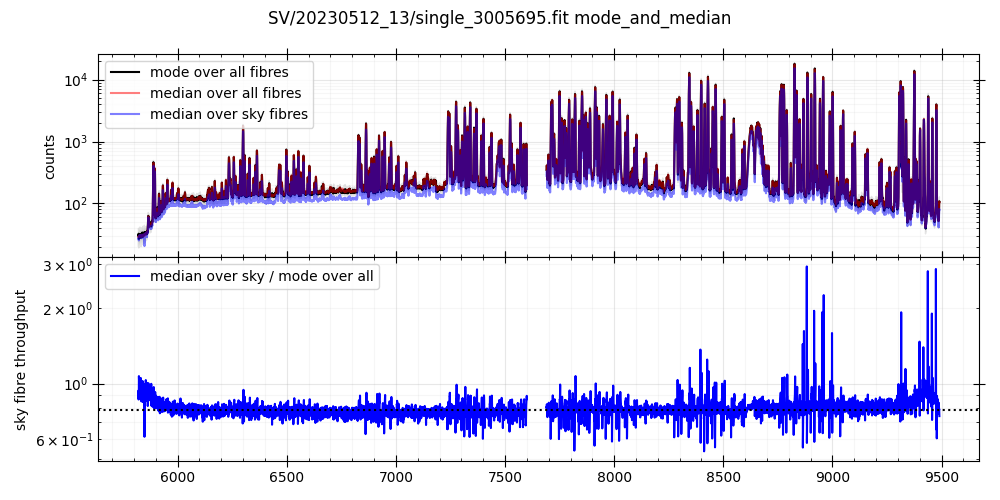

In [15]:
fig, axes = new_figure('mode_and_median', nrows=2)

ax = axes[0, 0]
ax.set_ylabel('counts')
ax.set_yscale('log')

ax.plot(rss.wavelength, mode_sky, 'k-', alpha=1, label='mode over all fibres')
ax.fill_between(rss.wavelength, mode_sky-delta_mode_sky, mode_sky+delta_mode_sky, color='k', alpha=.1)
ax.plot(rss.wavelength, median_sky_all, 'r-', alpha=.5, label='median over all fibres')
ax.plot(rss.wavelength, median_sky_fibres, 'b-', alpha=.5, label='median over sky fibres')
ax.legend()

ax = axes[1, 0]
ax.set_ylabel('sky fibre throughput')
ax.set_yscale('log')
ax.plot(rss.wavelength, median_sky_fibres/mode_sky, 'b-', label='median over sky / mode over all')
ax.axhline(np.nanmedian(median_sky_fibres/mode_sky), c='k', ls=':')
ax.legend()

plt.show()

In [16]:
#np.savetxt('sky_spectrum.txt', np.array([rss.wavelength, mode_sky]).T, fmt='%.1f', header='wavelength, sky_spectrum')

## Line Spread Function (LSF)

Parameters:

In [17]:
LSF_requested_resolution = 0.01  # Angstrom
LSF_wavelength_range = 20  # Angstrom
LSF_dlambda = np.arange(-LSF_wavelength_range, LSF_wavelength_range+.5*LSF_requested_resolution, LSF_requested_resolution)

Function definitions:

In [18]:
def normalise(x):
    x -= np.median(x)
    norm = x[x.size//2]
    if norm > 0:
        x /= norm
    else:
        x *= np.nan
    return x


def find_LSF(delta_l, spectrum):
    median_skyline = np.zeros((rss.sky_lines['wavelength'].size, delta_l.size))
    for i, line in enumerate(rss.sky_lines['wavelength']):
        sed = np.interp(line+delta_l, rss.wavelength, spectrum)
        sed = normalise(sed)
        median_skyline[i] = sed
    return normalise(np.nanmedian(median_skyline, axis=0))


def find_FWHM(delta_l, profile):
    threshold = np.max(profile)/2
    left = np.max(delta_l[(delta_l < 0) & (profile < threshold)])
    right = np.min(delta_l[(delta_l > 0) & (profile < threshold)])
    return right-left


In [19]:
def gaussian_profile(x, mu=0, sigma=1, norm=True):
    g = np.exp(-.5 * ((x-mu) / sigma)**2)
    if norm:
        g /= np.sqrt(2*np.pi) * sigma
    return  g


def refine_Gaussian(x, I, mu0, sigma0):

    good = np.where(np.isfinite(I))
    weight = np.exp(-.5 * ((x[good]-mu0) / sigma0)**2) * (I[good] - np.min(I[good]))
    total_weight = np.sum(weight)

    ivar0 = 1 / sigma0**2
    mu = np.sum(weight * x[good]) / total_weight
    ivar = total_weight / np.sum(weight * (x[good] - mu)**2)

    ivar1 = ivar - ivar0
    mu1 = (mu*ivar - mu0*ivar0) / ivar1
    return mu1, 1/np.sqrt(ivar1)


def fit_Gaussian(x, I, mu0=None, sigma0=None):

    if mu0 is None:
        mu0 = np.nanmean(x)
    if sigma0 is None:
        sigma0 = np.nanstd(x)
    
    delta2 = np.inf
    while delta2 > LSF_requested_resolution**2:
        mu1, sigma1 = refine_Gaussian(x, I, mu0, sigma0)
        delta2 = (mu1 - mu0)**2 + (sigma1 - sigma0)**2
        mu0 = mu1
        sigma0 = sigma1
        #print(mu0, sigma0)
    
    return mu0, sigma0

FWHM of mode-based sky:

In [20]:
mode_sky_LSF = find_LSF(LSF_dlambda, mode_sky)
mode_sky_FWHM = find_FWHM(LSF_dlambda, mode_sky_LSF)
#LSF_sigma = mode_sky_FWHM / np.sqrt(8*np.log(2))

LSF_mu, LSF_sigma = fit_Gaussian(LSF_dlambda, mode_sky_LSF, 0, mode_sky_FWHM / np.sqrt(8*np.log(2)))

print(f'FWHM of mode-based sky = {mode_sky_FWHM:.3f} (sigma = {mode_sky_FWHM / np.sqrt(8*np.log(2)):.3f}) Angstrom')
print(f'Moments (mu, sigma) = ({LSF_mu:.3f}, {LSF_sigma:.3f}) Angstrom')

FWHM of mode-based sky = 3.050 (sigma = 1.295) Angstrom
Moments (mu, sigma) = (-0.258, 1.320) Angstrom


Text(0.5, 0, '$(\\lambda - \\lambda_0)$ [$\\AA$]')

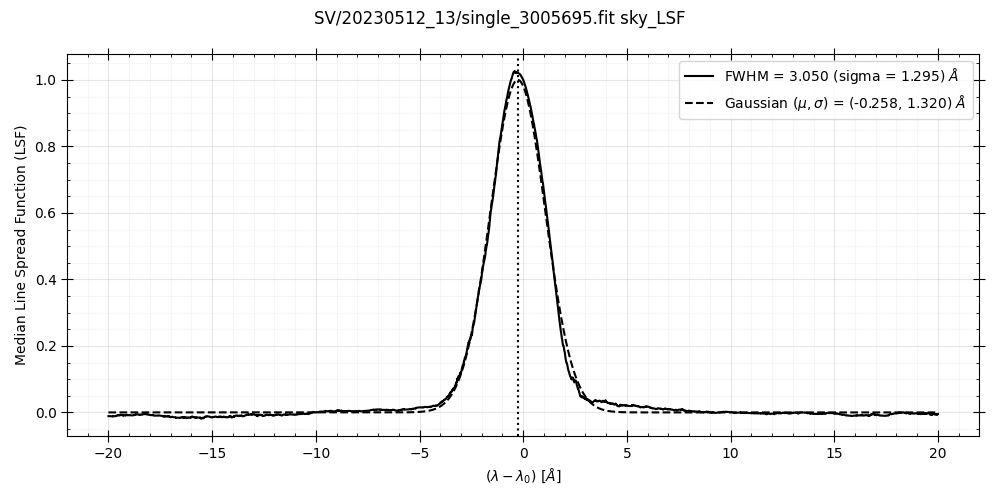

In [21]:
fig, axes = new_figure('sky_LSF')

    
ax = axes[0, 0]
ax.set_ylabel(r'Median Line Spread Function (LSF)')
#ax.set_yscale('log')
#ax.set_ylim(5e-4, 2)


#ax.plot(LSF_dlambda, np.nancumsum(mode_sky_LSF), 'k--', alpha=.5)
#ax.plot(LSF_dlambda, np.nancumsum(mode_sky_LSF*LSF_dlambda)*np.nancumsum(mode_sky_LSF), 'b-', alpha=.5)
ax.plot(LSF_dlambda, mode_sky_LSF, 'k-', alpha=1, label=f'FWHM = {mode_sky_FWHM:.3f} (sigma = {mode_sky_FWHM / np.sqrt(8*np.log(2)):.3f}) $\\AA$ ')
ax.plot(LSF_dlambda, gaussian_profile(LSF_dlambda, LSF_mu, LSF_sigma, False), 'k--', alpha=1, label=f'Gaussian ($\\mu, \\sigma$) = ({LSF_mu:.3f}, {LSF_sigma:.3f}) $\\AA$ ')
ax.axvline(LSF_mu, c='k', ls=':')
ax.legend()

ax = axes[-1, 0]
ax.set_xlabel(r'$(\lambda - \lambda_0)$ [$\AA$]')

# 3. Individual fibres

## Line-continuum separation

Parameters:

In [22]:
continuum_peak_separation = 2  # in units of the LSF FWHM

Function definitions:

In [23]:
'''
def find_peaks(x, y, min_separation):
    peaks = []
    y[np.isnan(y)] = -np.inf
    for i in range(min_separation, y.size-min_separation-1):
        if np.argmax(y[i-min_separation:i+min_separation+1]) == min_separation:
            valleys.append(i)
    y[~np.isfinite(y)] = np.nan
    return peaks
'''

def find_continuum(x, y, min_separation):
    valleys = []
    y[np.isnan(y)] = np.inf
    for i in range(min_separation, y.size-min_separation-1):
        if np.argmin(y[i-min_separation:i+min_separation+1]) == min_separation:
            valleys.append(i)
    y[~np.isfinite(y)] = np.nan
    return np.fmin(y, np.interp(x, x[valleys], y[valleys]))


Find continuum for all fibres:

In [24]:
t0 = time()
spectral_resolution = (rss.wavelength[-1] - rss.wavelength[0]) / rss.wavelength.size
continuum = np.empty_like(rss.counts)
for i, spectrum in enumerate(rss.counts):
    continuum[i] = find_continuum(rss.wavelength, spectrum, int(continuum_peak_separation*mode_sky_FWHM/spectral_resolution))
print(f"{rss.n_fibres} fibres ({time()-t0:.3g} s)")

600 fibres (15.4 s)


Identify strong sky emission lines:

In [25]:
line_fraction = 1-continuum/rss.counts
line_threshold = np.nanmedian(line_fraction)
#line_threshold = .5

line_mask = np.all(line_fraction > line_threshold, axis=0)
print(f'{np.count_nonzero(line_mask)} out of {rss.wavelength.size} wavelengths identified as strong sky lines (line fraction > {line_threshold:.3f})')

1446 out of 7341 wavelengths identified as strong sky lines (line fraction > 0.260)


In [26]:
line_mask[0] = False
line_mask[-1] = False
line_left = np.where(~line_mask[:-1] & line_mask[1:])[0]
line_right = np.where(line_mask[:-1] & ~line_mask[1:])[0]
line_right += 1

Use the sky spectrum as an illustrative example:

In [27]:
sky_continuum = find_continuum(rss.wavelength, mode_sky, int(continuum_peak_separation*mode_sky_FWHM/spectral_resolution))

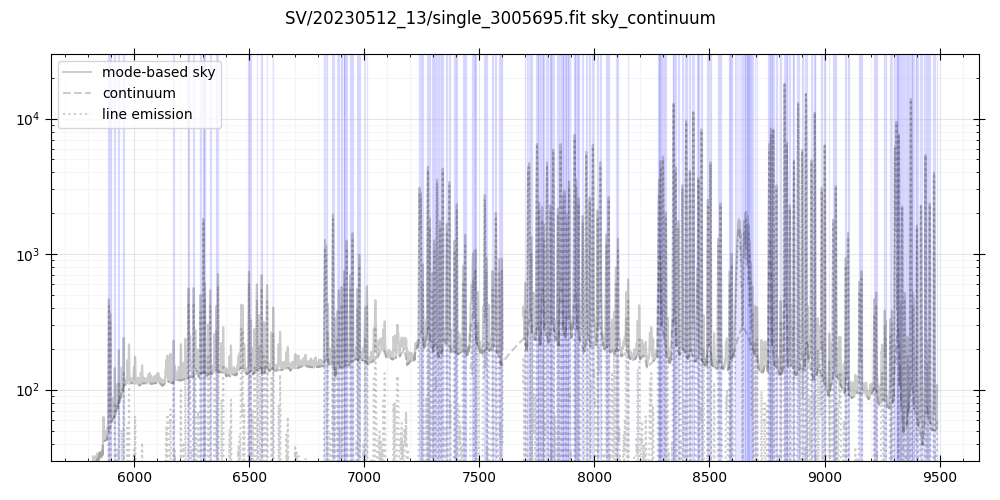

In [28]:
fig, axes = new_figure('sky_continuum')

ax = axes[0, 0]
ax.set_yscale('log')
ax.set_ylim(30, 3e4)

ax.plot(rss.wavelength, mode_sky, 'k-', alpha=.2, label='mode-based sky')
ax.plot(rss.wavelength, sky_continuum, 'k--', alpha=.2, label='continuum')
ax.plot(rss.wavelength, mode_sky - sky_continuum, 'k:', alpha=.2, label='line emission')
ax.legend()

for left, right in zip(line_left, line_right):
    ax.axvspan(rss.wavelength[left], rss.wavelength[right], color='b', alpha=.1)

plt.show()

## Trace lines through fibres

Use the continuum-subtracted sky lines as a reference spectrum:

In [29]:
reference_spectrum = mode_sky - sky_continuum

In [31]:
line_reference_wavelength = []
line_fit_weight = []  # used only for the fit
line_reference_intensity = []
for left, right in zip(line_left, line_right):
    weight = (reference_spectrum[left:right])**2
    line_reference_wavelength.append(np.nansum(weight * rss.wavelength[left:right]) / np.nansum(weight))
    line_fit_weight.append(np.nansum(reference_spectrum[left:right]))
    line_reference_intensity.append(np.nanmean(reference_spectrum[left:right]))
line_reference_wavelength = np.array(line_reference_wavelength)
line_fit_weight = np.array(line_fit_weight)
line_reference_intensity = np.array(line_reference_intensity)

Trace line wavelengths for every fibre to compare with the reference spectrum:

In [55]:
line_fibre_wavelength = []
line_fibre_intensity = []
for left, right in zip(line_left, line_right):
    weight = (rss.counts[:, left:right] - continuum[:, left:right])**2
    line_fibre_wavelength.append(np.nansum(weight * rss.wavelength[np.newaxis, left:right], axis=1) / np.nansum(weight, axis=1))
    line_fibre_intensity.append(np.nanmean(rss.counts[:, left:right] - continuum[:, left:right], axis=1))
line_fibre_wavelength = np.array(line_fibre_wavelength)
line_fibre_intensity = np.array(line_fibre_intensity)

Fit wavelength dependence:

In [33]:
fit_npoints = 18

In [34]:
fit_bins = np.linspace(line_reference_wavelength[0], line_reference_wavelength[-1], fit_npoints+1)
line_bin = np.searchsorted(fit_bins, line_reference_wavelength).clip(1, fit_npoints)
line_bin -=1
fit_bin_weight = np.zeros(fit_npoints)
np.add.at(fit_bin_weight, line_bin, line_fit_weight)
line_fit_weight /= fit_bin_weight[line_bin]

In [35]:
#fit = np.zeros(rss.n_fibres)
fit_points_x = np.zeros(fit_npoints)
np.add.at(fit_points_x, line_bin, line_reference_wavelength*line_fit_weight)
fit_points_y = np.zeros((rss.n_fibres, fit_npoints))
for fibre in range(rss.n_fibres):
    np.add.at(fit_points_y[fibre], line_bin, (line_fibre_wavelength[:, fibre]-line_reference_wavelength)*line_fit_weight)


Plot results:

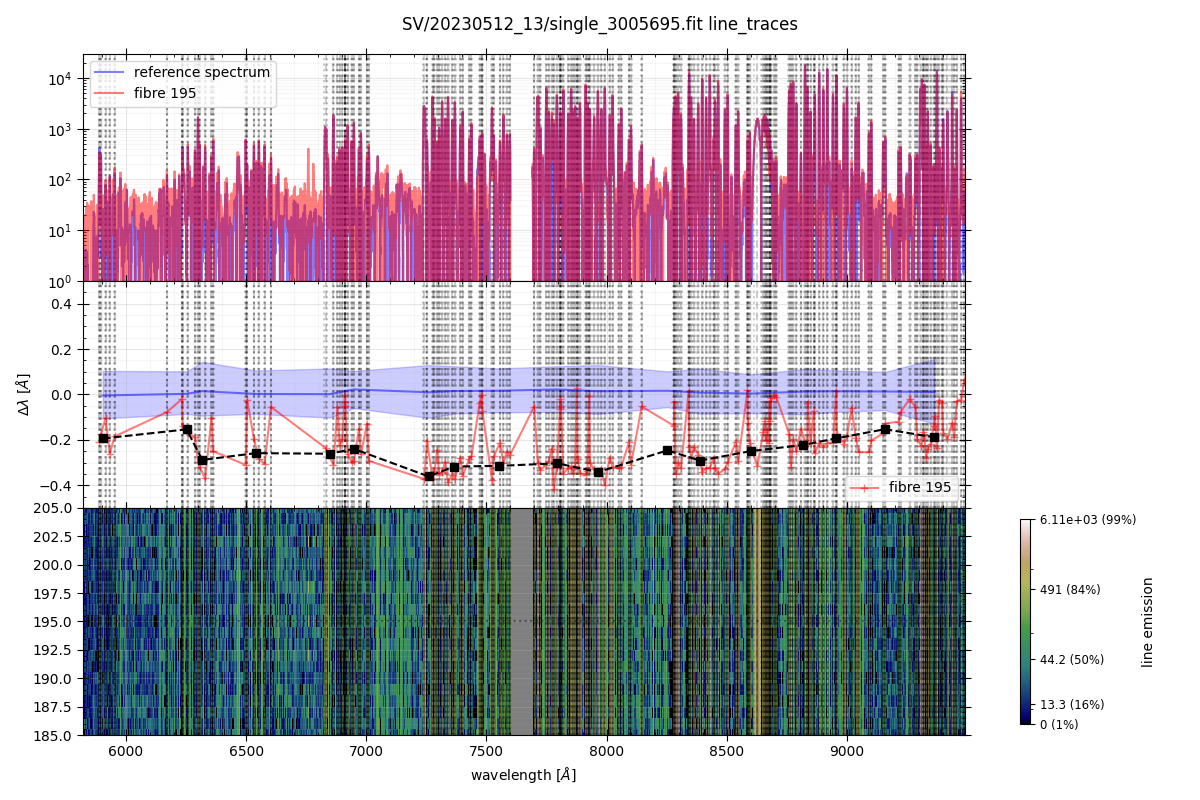

In [45]:
random_fibre = np.random.randint(0, rss.n_fibres)
random_fibre = 195

fig, axes = new_figure('line_traces', figsize=(12, 8), nrows=3)

for ax in axes.flat:
    for line in line_left:
        ax.axvline(rss.wavelength[line], c='k', ls=':', alpha=.2)
    for line in line_right:
        ax.axvline(rss.wavelength[line], c='k', ls=':', alpha=.2)
    for line in line_reference_wavelength:
        ax.axvline(line, c='k', ls='--', alpha=.2)

ax = axes[0, 0]
ax.set_yscale('log')
ax.set_ylim(1, 3e4)

ax.plot(rss.wavelength, reference_spectrum, 'b-', alpha=.5, label='reference spectrum')
ax.plot(rss.wavelength, rss.counts[random_fibre] - continuum[random_fibre], 'r-', alpha=.5, label=f'fibre {random_fibre}')

ax.legend()


ax = axes[1, 0]
ax.set_ylabel(r'$\Delta \lambda$ [$\AA$]')
#ax.set_yscale('log')
ax.set_ylim(-.5, .5)

#for fibre in range(rss.n_fibres):
#    ax.plot(line_reference_wavelength, line_fibre_wavelength[:, fibre] - line_reference_wavelength, 'c-', alpha=.02)

ax.plot(line_reference_wavelength, line_fibre_wavelength[:, random_fibre] - line_reference_wavelength, 'r+-', alpha=.5, label=f'fibre {random_fibre}')
ax.legend(loc='lower right')
'''
ax.plot(rss.wavelength, wavelength_correction_zero_point[random_fibre] + wavelength_correction_slope[random_fibre]*rss.wavelength, 'c--',
       label=f'Linear fit to fibre {random_fibre}')
'''
ax.plot(fit_points_x, fit_points_y[random_fibre], 'ks--', alpha=1)

ax.plot(fit_points_x, np.nanmedian(fit_points_y, axis=0), 'b-', alpha=.5)
ax.fill_between(fit_points_x, np.percentile(fit_points_y, 16, axis=0), np.percentile(fit_points_y, 84, axis=0), color='b', alpha=.2)

ax = axes[2, 0]
ax.set_ylim(random_fibre-10, random_fibre+10)

im, cb = colour_map(ax, 'line emission', rss.counts-continuum, xlabel='', x=rss.wavelength)
dummy_cb = fig.colorbar(None, ax=axes[0, 0], orientation='vertical', shrink=.9)
dummy_cb.ax.clear()
dummy_cb.ax.axis('off')
dummy_cb = fig.colorbar(im, ax=axes[1, 0], orientation='vertical', shrink=.9)
dummy_cb.ax.clear()
dummy_cb.ax.axis('off')

ax.axhline(random_fibre, c='k', ls=':', alpha=.4)
for line in line_fibre_wavelength:
    ax.plot(line, np.arange(rss.n_fibres), 'k-', alpha=.4)


ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
plt.show()

## Wavelength correction

In [112]:
line_offset = line_fibre_wavelength - line_reference_wavelength[:, np.newaxis]
p16_line_offset, median_line_offset, p84_line_offset = np.nanpercentile(line_offset, [16, 50, 84], axis=0)
model_line_offset = line_offset - median_line_offset[np.newaxis, :]
model_line_offset = median_line_offset[np.newaxis, :] + ndimage.gaussian_filter(model_line_offset, 2)

In [113]:
p16_corrected_offset, median_corrected_offset, p84_corrected_offset = np.nanpercentile(line_offset - model_line_offset, [16, 50, 84], axis=0)

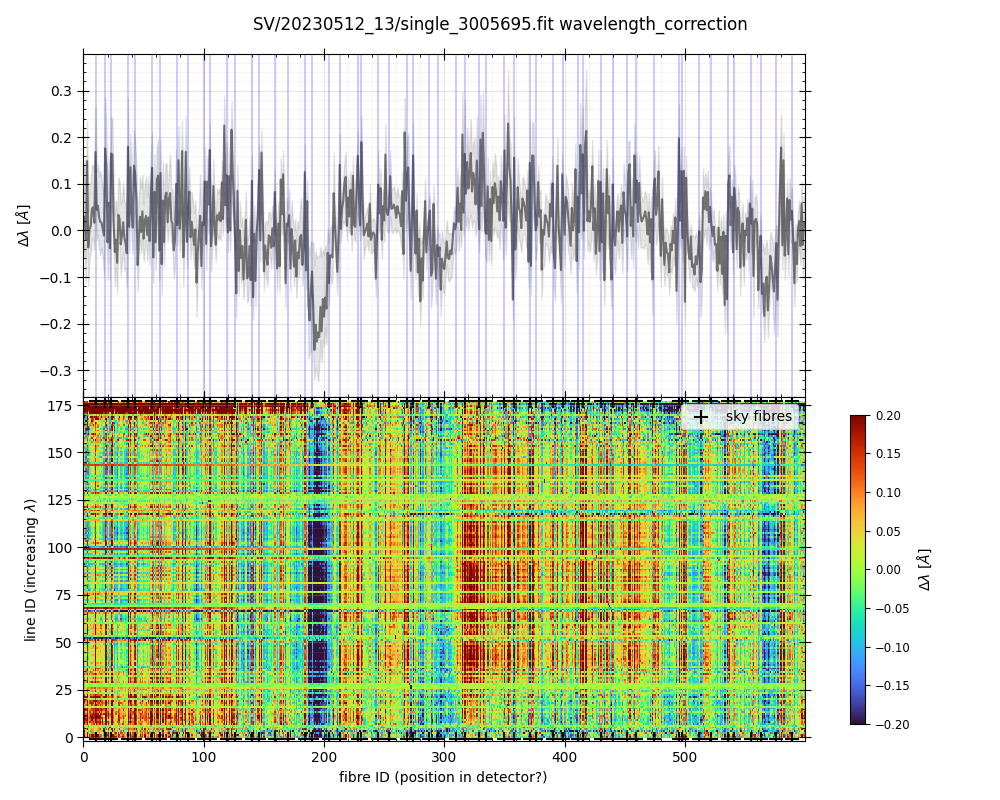

In [126]:
fig, axes = new_figure('wavelength_correction', figsize=(10, 8), nrows=2)

ax = axes[0, 0]
ax.set_ylabel('$\Delta\lambda$ [$\AA$]')
ax.plot(median_line_offset, 'k-', alpha=.5, label='original')
ax.fill_between(np.arange(rss.n_fibres), p16_line_offset, p84_line_offset, color='k', alpha=.1)
#ax.plot(median_corrected_offset, 'b-', alpha=.5, label='corrected')
#ax.fill_between(np.arange(rss.n_fibres), p16_corrected_offset, p84_corrected_offset, color='b', alpha=.1)
#ax.legend()
for line in rss.sky_fibres[0]:
    ax.axvline(line, c='b', ls='-', alpha=.2)
cb = fig.colorbar(None, ax=ax)
cb.remove()


ax = axes[1, 0]
im, cb = colour_map(ax, '$\Delta\lambda$ [$\AA$]', line_offset,
                    xlabel='fibre ID (position in detector?)', ylabel='line ID (increasing $\lambda$)', cmap='turbo', norm=colors.Normalize(vmin=-.2, vmax=.2))
ax.scatter(rss.sky_fibres, -np.ones_like(rss.sky_fibres), s=100, marker='+', c='k', label='sky fibres')
ax.scatter(rss.sky_fibres, line_reference_intensity.size*np.ones_like(rss.sky_fibres), s=100, marker='+', c='k')
ax.legend()
ax.set_ylim(-2, line_reference_intensity.size+2)

'''
ax = axes[2, 0]
im, cb = colour_map(ax, '$\Delta\lambda$ - median $\Delta\lambda$ [$\AA$]', model_line_offset,
                    xlabel='fibre ID (position in detector?)', ylabel='line ID (increasing $\lambda$)', cmap='turbo', norm=colors.Normalize(vmin=-.2, vmax=.2))
ax.scatter(rss.sky_fibres, -np.ones_like(rss.sky_fibres), s=100, marker='+', c='k', label='sky fibres')
ax.scatter(rss.sky_fibres, line_reference_intensity.size*np.ones_like(rss.sky_fibres), s=100, marker='+', c='k')
ax.legend()
ax.set_ylim(-2, line_reference_intensity.size+2)


ax = axes[3, 0]
im, cb = colour_map(ax, '$\Delta\lambda$ - median $\Delta\lambda$ [$\AA$]', line_offset - model_line_offset,
                    xlabel='fibre ID (position in detector?)', ylabel='line ID (increasing $\lambda$)', cmap='turbo', norm=colors.Normalize(vmin=-.2, vmax=.2))
ax.scatter(rss.sky_fibres, -np.ones_like(rss.sky_fibres), s=100, marker='+', c='k', label='sky fibres')
ax.scatter(rss.sky_fibres, line_reference_intensity.size*np.ones_like(rss.sky_fibres), s=100, marker='+', c='k')
ax.legend()
ax.set_ylim(-2, line_reference_intensity.size+2)
'''


plt.show()

## Fibre flat

In [130]:
fibre_flat = line_fibre_intensity / line_reference_intensity[:, np.newaxis]
p16_fibre_flat, median_fibre_flat, p84_fibre_flat = np.nanpercentile(fibre_flat, [16, 50, 84], axis=0)

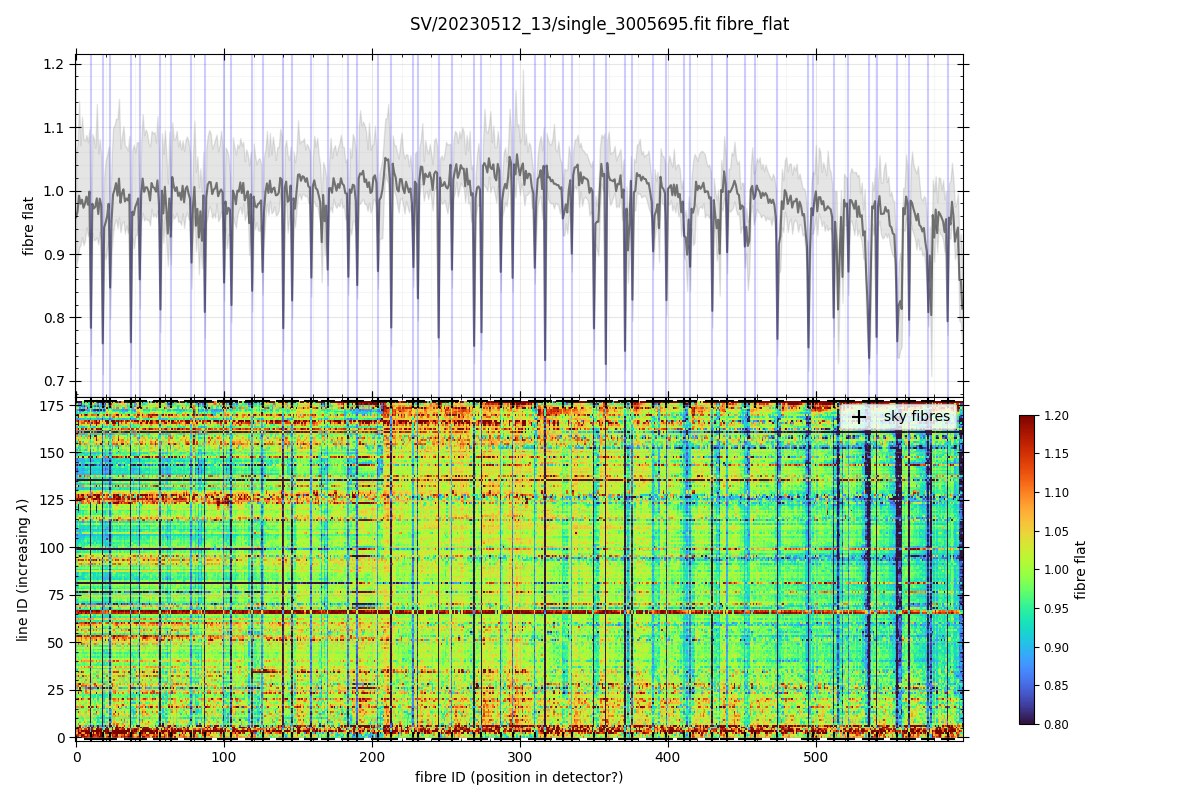

In [132]:
fig, axes = new_figure('fibre_flat', figsize=(12, 8), nrows=2)

ax = axes[0, 0]
ax.set_ylabel('fibre flat')
ax.plot(median_fibre_flat, 'k-', alpha=.5)
ax.fill_between(np.arange(rss.n_fibres), p16_fibre_flat, p84_fibre_flat, color='k', alpha=.1)
for line in rss.sky_fibres[0]:
    ax.axvline(line, c='b', ls='-', alpha=.2)
cb = fig.colorbar(None, ax=ax)
cb.remove()


ax = axes[1, 0]
im, cb = colour_map(ax, 'fibre flat', fibre_flat,
                    xlabel='fibre ID (position in detector?)', ylabel='line ID (increasing $\lambda$)', cmap='turbo', norm=colors.Normalize(vmin=.8, vmax=1.2))
ax.scatter(rss.sky_fibres, -np.ones_like(rss.sky_fibres), s=100, marker='+', c='k', label='sky fibres')
ax.scatter(rss.sky_fibres, line_reference_intensity.size*np.ones_like(rss.sky_fibres), s=100, marker='+', c='k')
ax.legend()
ax.set_ylim(-2, line_reference_intensity.size+2)


plt.show()

# --- OLD STUFF ---

## Fibre flat

In [ ]:
fibre_flat = (rss.counts - continuum) * line_mask[np.newaxis, :]
fibre_flat /= reference_spectrum[np.newaxis, :] * line_mask[np.newaxis, :]

In [ ]:
high_res, low_res = np.nanpercentile(fibre_FWHM, [100/3, 200/3])
sky_high_res = np.nanmedian(rss.sky_counts[rss.sky_fibres][fibre_FWHM < high_res], axis=0)
sky_low_res = np.nanmedian(rss.sky_counts[rss.sky_fibres][fibre_FWHM > low_res], axis=0)
print(f'high and low resolution: FWHM < {high_res}, FWHM > {low_res} AA (mode sky: {mode_sky_FWHM})')

Plots:

In [ ]:
fig_name = 'LSF'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 5))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')

    
ax = axes[0, 0]
ax.set_ylabel(r'Median Line Spread Function (LSF)')
ax.set_yscale('log')
ax.set_ylim(5e-4, 2)

for fibre in range(rss.n_sky_fibres):
    ax.plot(LSF_dlambda, fibre_LSF[fibre], 'c-', alpha=.1)
ax.plot(LSF_dlambda, mode_sky_LSF, 'k-', alpha=1, label=f'FWHM of median sky: {mode_sky_FWHM:.3g} $\\AA$ ')
p1, p16, p50, p84, p99 = np.nanpercentile(fibre_FWHM, [1, 16, 50, 84, 99])
ax.plot(LSF_dlambda, np.nanmedian(fibre_LSF, axis=0), 'r-', alpha=1, label=f'individual sky fibres: ({p1:.3g}, {p16:.3g}, {p50:.3g}, {p84:.3g}, {p99:.3g})')
ax.legend()

ax = axes[-1, 0]
ax.set_xlabel(r'$(\lambda - \lambda_0)$ [$\AA$]')

## Peak finding

Convolution

In [ ]:
resolution_boost = 8
model_wave = np.linspace(rss.wavelength[0], rss.wavelength[-1], resolution_boost*rss.wavelength.size)
dl = model_wave - np.mean(model_wave)
kernel = np.interp(dl, LSF_dlambda, np.nanmedian(fibre_LSF, axis=0))
kernel[np.isnan(kernel)] = 0
kernel *= np.exp(-(dl/median_sky_FWHM)**2)
kernel = np.fft.rfftn(kernel)

def find_peaks(spectrum):
    signal = np.interp(model_wave, rss.wavelength, spectrum)
    signal[np.isnan(signal)] = 0

    model = np.fft.rfftn(signal)
    model = np.fft.irfftn(model*np.absolute(kernel))/2/np.pi/resolution_boost
    peaks = np.empty_like(model_wave)
    peaks[1:-1] = np.where((model[1:-1] > model[:-2]) & (model[1:-1] > model[2:]), model[1:-1], 0)
    peaks[0] = peaks[-1] = 0
    
    return peaks


In [ ]:
median_peaks = find_peaks(median_sky)

In [ ]:
fibre_peaks = np.empty((rss.n_sky_fibres, model_wave.size))
for i, fibre in enumerate(rss.sky_fibres[0]):
    fibre_peaks[i] = find_peaks(rss.counts[fibre])

In [ ]:
median_peak_wave = model_wave[median_peaks > 0]
median_peak_height = median_peaks[median_peaks > 0]

Matching/tracking peaks accross fibres

In [ ]:
candidates = np.where(fibre_peaks > 0)
best_match_wave = np.zeros((median_peak_wave.size, rss.n_sky_fibres))
best_match_height = np.zeros((median_peak_wave.size, rss.n_sky_fibres))
for i, line in enumerate(median_peak_wave):
    distance = np.inf*np.ones_like(fibre_peaks)
    distance[candidates] = ((line - model_wave[candidates[1]]) / median_sky_FWHM)**2 #+ (np.log(median_peak_height[i]/fibre_peaks[candidates]) / .1)**2    
    match = np.argmin(distance, axis=1)
    best_match_wave[i] = model_wave[match]
    best_match_height[i] = fibre_peaks[np.arange(rss.n_sky_fibres), match]

Keep only "a few" robust" peaks (somewhat arbitrary)

In [ ]:
median_peak_jitter = np.std(best_match_wave, axis=1)
p16, p50, p84 = np.nanpercentile(median_peak_jitter, [16, 50, 84])
jitter_threshold = p50
p16, p50, p84 = np.nanpercentile(median_peak_height, [16, 50, 84])
height_threshold = p50
good_peak = np.where((median_peak_jitter < jitter_threshold) & (median_peak_height > height_threshold))

## Wavelength calibration and fibre flat

Fit linear functions $a_i+b_i\lambda$ to wavelength corrections and fibre flat of each fibre $i$ as a function of wavelength

In [ ]:
def fit_correction(wavelength, correction):
    lambda0 = np.nanmean(wavelength)

    left = np.where(wavelength < lambda0)
    lambda_left = np.nanmean(wavelength[left])
    correction_left = np.nanmedian(correction[left], axis=0)

    right = np.where(wavelength > lambda0)
    lambda_right = np.nanmean(wavelength[right])
    correction_right = np.nanmedian(correction[right], axis=0)
    
    slope  = (correction_right - correction_left) / (lambda_right - lambda_left)
    zero_point = correction_left - slope*lambda_left
    return zero_point, slope

fibre_flat_zero_point, fibre_flat_slope = fit_correction(median_peak_wave[good_peak], best_match_height[good_peak]/median_peak_height[good_peak][:, np.newaxis])
wavelength_correction_zero_point, wavelength_correction_slope = fit_correction(median_peak_wave[good_peak], best_match_wave[good_peak] - median_peak_wave[good_peak][:, np.newaxis])

Apply corrections (leave fancier interpolation as future work ;^D):

In [ ]:
corrected_counts = rss.counts[rss.sky_fibres] / (fibre_flat_zero_point[:, np.newaxis] + fibre_flat_slope[:, np.newaxis]*rss.wavelength[np.newaxis, :])
corrected_wave = rss.wavelength - (wavelength_correction_zero_point[:, np.newaxis] + wavelength_correction_slope[:, np.newaxis]*rss.wavelength[np.newaxis, :])

for i in range(rss.n_sky_fibres):
    corrected_counts[i] = np.interp(rss.wavelength, corrected_wave[i], corrected_counts[i])

## Sky subtraction

In [ ]:
high_res, low_res = np.nanpercentile(fibre_FWHM, [100/3, 200/3])
sky_high_res = np.nanmedian(corrected_counts[fibre_FWHM < high_res], axis=0)
sky_low_res = np.nanmedian(corrected_counts[fibre_FWHM > low_res], axis=0)
sky_mid_res = np.nanmedian(corrected_counts, axis=0)
print(f'high and low resolution: FWHM < {high_res}, FWHM > {low_res} AA (median sky: {median_sky_FWHM})')

In [ ]:
def get_sky(FWHM):
    w = np.clip((FWHM - high_res) / (low_res - high_res), 0, 1)
    w_high = 1 - w**2
    w_low = w**2
    w_med = 4*w*(1-w)
    return (w_high*sky_high_res + w_med*sky_mid_res + w_low*sky_low_res) / (w_high + w_med + w_low)

In [ ]:
sky_subtracted = np.empty_like(corrected_counts)

for i in range(rss.n_sky_fibres):
    sky_subtracted[i] = corrected_counts[i] - get_sky(fibre_FWHM[i])

## Plot results

In [ ]:
random_fibre = np.random.randint(0, rss.n_sky_fibres)
random_fibre = 306

In [ ]:
fig_name = 'good_peak_selection'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 5))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')

    
ax = axes[0, 0]
ax.set_ylabel(r'peak jitter [$\AA$]')
ax.set_yscale('log')

ax.plot(median_peak_height, median_peak_jitter, 'k+', alpha=1)
ax.plot(median_peak_height[good_peak], median_peak_jitter[good_peak], 'go', alpha=.5)
ax.axhline(jitter_threshold, c='k', ls=':')
ax.axvline(height_threshold, c='k', ls=':')

#ax = axes[-1, 0]
ax.set_xlabel('peak height [counts]')
ax.set_xscale('log')


In [ ]:
fig_name = 'corrections_1D'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=3, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')

    
ax = axes[0, 0]
ax.set_ylabel(r'strong sky emission lines [counts]')
ax.set_yscale('log')
ax.set_ylim(np.nanmin(median_sky), np.nanmax(median_sky))

ax.plot(rss.wavelength, median_sky, 'r-', alpha=.4, label='median sky')
ax.plot(rss.wavelength, sky_high_res, 'k--', alpha=.4, label=f'FWHM < {high_res:.2f}')
ax.plot(rss.wavelength, sky_low_res, 'k:', alpha=.4, label=f'FWHM > {low_res:.2f}')

#ax.plot(LSF_dlambda, median_sky_LSF, 'k-', alpha=1, label=f'FWHM of median sky: {median_sky_FWHM:.3g} $\\AA$ ')
ax.plot(median_peak_wave, median_peak_height, 'k+', alpha=1, label='detected peaks')
ax.plot(median_peak_wave[good_peak], median_peak_height[good_peak], 'go', alpha=.5, label='strong peaks')
ax.legend()


ax = axes[1, 0]
ax.set_ylabel(r'wavelength correction $\Delta \lambda$ [$\AA$]')
#ax.set_yscale('log')
ax.set_ylim(-.5, .5)

for fibre in range(rss.n_sky_fibres):
    ax.plot(median_peak_wave[good_peak], (best_match_wave[good_peak, fibre] - median_peak_wave[good_peak]).flat, 'k-', alpha=.02)

ax.plot(median_peak_wave[good_peak], (best_match_wave[good_peak, random_fibre] - median_peak_wave[good_peak]).flat, 'r-', alpha=1,
       label=f'Fibre {random_fibre} (random example)')
ax.plot(rss.wavelength, wavelength_correction_zero_point[random_fibre] + wavelength_correction_slope[random_fibre]*rss.wavelength, 'c--',
       label=f'Linear fit to fibre {random_fibre}')
ax.legend()


ax = axes[2, 0]
ax.set_ylabel('peak height (fibre flat)')
#ax.set_yscale('log')
ax.set_ylim(.75, 1.25)

for fibre in range(rss.n_sky_fibres):
    ax.plot(median_peak_wave[good_peak], (best_match_height[good_peak, fibre] / median_peak_height[good_peak]).flat, 'k-', alpha=.03)

ax.plot(median_peak_wave[good_peak], (best_match_height[good_peak, random_fibre] / median_peak_height[good_peak]).flat, 'r-', alpha=1,
       label=f'Fibre {random_fibre} (random example)')
ax.plot(rss.wavelength, fibre_flat_zero_point[random_fibre] + fibre_flat_slope[random_fibre]*rss.wavelength, 'c--',
       label=f'Linear fit to fibre {random_fibre}')
ax.legend()


ax = axes[-1, 0]
ax.set_xlabel(r'observed wavelength [$\AA$]')
plt.savefig(f'{fig_name}.pdf')

In [ ]:
fig_name = 'corrections_2D'
plt.close(fig_name)

nrows = 4
ncols = 1
panel_width = 10
panel_height = 2
cbar_fraction = .01

fig = plt.figure(fig_name, figsize=(ncols*panel_width/(1-cbar_fraction), nrows*panel_height))
axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)

def show_data(x, data, ax, title, angle=0, cmap='nipy_spectral', norm=None):
    #percentiles = np.array([0, 16, 50, 84, 100])
    percentiles = np.array([1, 16, 50, 84, 99])
    ticks = np.nanpercentile(data, percentiles)
    median = ticks[np.argmin(np.abs(percentiles-50))]
    std = np.std(data[data < median])
    if norm is None:
        norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=median+2*std)
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, -.5, data.shape[0]-.5),
                   cmap=cmap,
                   norm=norm,
                   #norm=colors.SymLogNorm(vmin=-1e3, vmax=1e3, linthresh=10),
                   #norm=colors.SymLogNorm(vmin=median-3*std, vmax=ticks[-1], linthresh=median+3*std),
                  )
    ax.set_aspect('auto')
    ax.set_ylabel('sky fibre')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9, fraction=cbar_fraction)
    cb.ax.set_ylabel(title)
    cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)],
                     fontsize='small', rotation=angle)


#norm = colors.LogNorm(vmin=10, vmax=1e4)
norm = colors.SymLogNorm(vmin=-1e3, vmax=1e4, linthresh=5)
cmap = 'gist_heat'
cmap = 'gist_earth'

show_data(rss.wavelength, rss.counts[rss.sky_fibres], axes[0, 0], 'raw counts', cmap=cmap, norm=norm)
#ax = axes[0, 0]
#for peak in good_peak[0]:
#    ax.plot(best_match_wave[peak], np.arange(rss.n_sky_fibres), 'k-', alpha=.5)

show_data(rss.wavelength, corrected_counts, axes[1, 0], 'corrected', cmap=cmap, norm=norm)


show_data(rss.wavelength, rss.counts[rss.sky_fibres]-rss.sky_counts[0], axes[2, 0], 'original subtraction', cmap=cmap, norm=norm)
show_data(rss.wavelength, sky_subtracted, axes[3, 0], 'this pipeline', cmap=cmap, norm=norm)

axes[-1, 0].set_xlabel(r'wavelength [$\AA$]')
#axes[-1, 0].set_xlim(8900, 9100)

'''
for ax in axes.flat:
    for i in range(median_sky_bins.size-1):
        #ax.plot(fibre_flat_wave[:, i], np.arange(rss.sky_fibres[0].size), 'k-')
        ax.plot(median_sky_bin_wave[i]+delta_lambda, np.arange(rss.n_sky_fibres), 'k-')
'''
plt.savefig(f'{fig_name}.pdf')

In [ ]:
fig_name = 'sky_subtraction'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
#ax.set_yscale('symlog', linthresh=1e3)
ax.set_ylim(-2.5e3, 1.25e4)
ax.plot(rss.wavelength, rss.counts[rss.sky_fibres][random_fibre], 'k-', alpha=.5, label=f'Fibre {random_fibre}')
ax.plot(rss.wavelength, rss.counts[rss.sky_fibres][random_fibre]-rss.sky_counts[0], 'b-', alpha=.3, label='original subtraction')
ax.plot(rss.wavelength, sky_subtracted[random_fibre], 'r-', alpha=1, label='this pipeline')
ax.legend()

axes[-1, 0].set_xlabel(r'wavelength [$\AA$]')
#axes[-1, 0].set_xlim(6700, 7000)
axes[-1, 0].set_xlim(8840, 9060)
plt.savefig(f'{fig_name}.pdf')

In [ ]:
fig_name = 'sky_residuals'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


def plot_fraction(x, ax, color, label):
    sorted_x = np.sort(x)
    sorted_x = sorted_x[np.isfinite(sorted_x)]
    n_negative = np.searchsorted(sorted_x, 0)
    n_positive = sorted_x.size - n_negative
    ax.plot(sorted_x[n_negative:], (n_positive - np.arange(n_positive))/sorted_x.size, c=color, ls='-', label=f'{label} (positive values)')
    ax.plot(-sorted_x[:n_negative], np.arange(n_negative)/sorted_x.size, c=color, ls='--', label=f'{label} (negative values)')

ax = axes[0, 0]
ax.set_ylabel(r'fraction')
ax.set_yscale('log')

plot_fraction((rss.counts[rss.sky_fibres] - rss.sky_counts[0]).flat, ax, 'b', 'original subtraction')
plot_fraction(sky_subtracted.flat, ax, 'r', 'this pipeline')
ax.legend()


ax = axes[-1, 0]
ax.set_xlabel(r'counts')
#ax.set_xscale('log')
#ax.set_xscale('symlog', linthresh=1000)
#ax.set_xlim(0, 3000)


## Richardson-Lucy deconvolution

In [ ]:
model_wave = np.arange(rss.wavelength[0], rss.wavelength[-1]+.5*LSF_requested_resolution, LSF_requested_resolution)
if model_wave.size % 2 == 1:
    model_wave = model_wave[:-1]

'''
fourier_kernel = np.zeros_like(model_wave)
fourier_kernel[:LSF_dlambda.size] = LSF_dlambda
#fourier_kernel /= np.nanmean(fourier_kernel)
sigma_LSF = .5*mode_sky_FWHM / np.sqrt(8*np.log(2))
'''
fourier_kernel = gaussian_profile(model_wave, model_wave[model_wave.size//2], LSF_sigma)
fourier_kernel *= LSF_requested_resolution
def gaussian_profile(x, mu=0, sigma=1, norm=True):
    g = np.exp(-.5 * ((x-mu) / sigma)**2)
    if norm:
        g /= np.sqrt(2*np.pi) * sigma
    return  g
fourier_kernel = np.absolute(np.fft.rfftn(fourier_kernel))

epsilon = 1e-3*np.min(mode_sky[mode_sky > 0])
print(epsilon)

def richardson_lucy_iteration(data, previous_iteration, fourier_kernel):
    estimate = np.fft.irfftn(np.fft.rfftn(previous_iteration) * fourier_kernel)
    #estimate += 1e-12*data # to prevent infinites
    #print(np.sum(estimate), np.nansum(data / estimate))
    return previous_iteration * np.fft.irfftn(np.fft.rfftn((data+epsilon) / (estimate+epsilon)) * fourier_kernel)


In [ ]:
t0 = time()
model_sky = np.interp(model_wave, rss.wavelength, mode_sky - sky_continuum)
model_continuum = np.interp(model_wave, rss.wavelength, sky_continuum)
model_sky[~np.isfinite(model_sky)] = 0
sky_RL = np.ones_like(model_wave)

RL_n_iter = 300
for i in range(RL_n_iter):
    #print(i, np.nansum(sky_RL))
    sky_RL = richardson_lucy_iteration(model_sky, sky_RL, fourier_kernel)

sky_estimate = np.fft.irfftn(np.fft.rfftn(sky_RL) * fourier_kernel)
print(f"{RL_n_iter} iterations ({time()-t0:.3g} s)")


In [ ]:
fig_name = 'Richardson_Lucy'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 5))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
ax.set_yscale('log')
ax.set_ylim(.3, 3e4)

ax.plot(rss.wavelength, mode_sky, 'k-', alpha=.5, label='observed sky')
ax.plot(model_wave, model_continuum, 'b--', alpha=.25, label='sky continuum')
#ax.fill_between(rss.wavelength, mode_sky-delta_mode_sky, mode_sky+delta_mode_sky, color='k', alpha=.1)
ax.plot(model_wave, model_continuum + sky_RL, 'r-', alpha=.5, label=f'R-L ({RL_n_iter} iterations)')
ax.plot(model_wave, sky_RL, 'y-', alpha=.5, label=f'R-L lines')
ax.plot(model_wave, model_continuum + sky_estimate, 'b-', alpha=.5, label='R-L model')
#ax.plot(model_wave, sky_estimate, 'c-', alpha=.5)

for line in rss.sky_lines:
    ax.axvline(line['wavelength'], c='k', ls=':', alpha=.2)

ax.legend(loc='upper left')

ax.set_xlim(6800, 6900)
plt.show()

In [ ]:
len(rss.sky_lines)

# 1. Raw counts and errors

## 2D plot

In [ ]:
fig_name = 'counts_errors_2D'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=4, ncols=1, squeeze=False,
                    sharex='col', sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)

def show_data(x, data, ax, title, angle=0):
    #percentiles = np.array([0, 16, 50, 84, 100])
    percentiles = np.array([1, 16, 50, 84, 99])
    ticks = np.nanpercentile(data, percentiles)
    median = ticks[np.argmin(np.abs(percentiles-50))]
    std = np.std(data[data < median])
    im = ax.imshow(data,
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, -.5, data.shape[0]-.5),
                   interpolation='nearest', origin='lower',
                   #cmap='nipy_spectral',
                   #cmap='terrain',
                   #cmap='gist_stern',
                   #cmap='ocean',
                   cmap='gist_earth',
                   #norm=colors.SymLogNorm(vmin=median-3*std, vmax=ticks[-1], linthresh=median+3*std),
                   norm=colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=median+3*std),
                  )
    ax.set_aspect('auto')
    ax.set_ylabel('fibre')
    #for fibre in rss.sky_fibres[0]:
    #    ax.axhline(fibre, c='k', ls=':', alpha=.3)
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(title)
    cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)], rotation=angle)


show_data(rss.wavelength, rss.counts, axes[0, 0], 'raw counts')
show_data(rss.wavelength, rss.counts_error, axes[1, 0], 'error')
show_data(rss.wavelength, rss.counts-rss.sky_counts, axes[2, 0], 'sky-subtracted')
show_data(rss.wavelength, np.abs(rss.counts-rss.sky_counts)/rss.counts_error, axes[3, 0], 'sky-subtracted S/N')
#show_data(rss.wavelength, rss.flux, axes[2, 0], 'flux')

axes[-1, 0].set_xlabel(r'wavelength [$\AA$]')


## Values

In [ ]:
'''
sorted_counts = np.sort(rss.counts.ravel())
sorted_counts = sorted_counts[np.isfinite(sorted_counts)]
N_counts = sorted_counts.size
y_counts = np.arange(N_counts)
y_counts = (y_counts+1)*(N_counts-y_counts)/N_counts

sorted_err = np.sort(rss.counts_error.ravel())
sorted_err = sorted_err[np.isfinite(sorted_err)]
N_err = sorted_err.size
y_err = np.arange(N_err)
y_err = (y_err+1)*(N_err-y_err)/N_err

fig_name = 'counts_errors'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(6, 6))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
ax.set_ylabel(r'$N_{below} \times N_{above} ~/~ N_{total}$')
ax.set_yscale('log')

ax.plot(sorted_counts, y_counts, 'k-', label='raw counts')
'''
#percentiles = np.array([0, 16, 50, 84, 100])
#for per, val in zip(percentiles, sorted_counts[percentiles*(N_counts-1)//100]):
#    ax.axvline(val, color='k', ls=':', label=f'{val:.4g} ({per}%)')
'''

median = sorted_counts[N_counts//2]
std = np.std(sorted_counts[:N_counts//2])
ax.axvspan(median-std, median+std, color='k', alpha=.1, label=f'{median:.3g} $\\pm$ {std:.3g}')
ax.legend()

ax.plot(sorted_err, y_err, 'r--', label='error')
'''
#for per, val in zip(percentiles, sorted_err[percentiles*(N_err-1)//100]):
#    ax.axvline(val, color='r', ls=':', label=f'{val:.4g} ({per}%)')
'''

median = sorted_err[N_err//2]
std = np.std(sorted_err[:N_err//2])
ax.axvspan(median-std, median+std, color='r', alpha=.1, label=f'{median:.3g} $\\pm$ {std:.3g}')
ax.legend(loc='upper left')


ax = axes[1, 0]
ax.set_ylabel(r'error')
ax.set_yscale('log')
ax.scatter(rss.counts.flat, rss.counts_error.flat, s=1, alpha=.01)

n_counts = np.logspace(-1, 5, 101)
electrons_per_count = 1  # initial guess
sigma_ron = np.sqrt(np.nanmedian((rss.counts_error**2 - rss.counts*electrons_per_count)))
electrons_per_count = np.sqrt(np.nanmedian((rss.counts_error**2 - sigma_ron**2)/rss.counts))
noise_transition = sigma_ron**2/electrons_per_count
ax.plot(n_counts, np.sqrt(sigma_ron**2 + electrons_per_count*n_counts), 'k--', label=f'readout noise = {sigma_ron:.3g} counts; gain = {electrons_per_count:.3g} e$^-$/count')
ax.axvline(noise_transition, c='r', ls=':', label=f'Poisson noise beyond {noise_transition:.3g} counts')

ax.legend(loc='upper left')


ax = axes[-1, 0]
ax.set_xlabel(r'counts')
ax.set_xscale('log')
'''
